In [1]:
from data.loaders import load_reddit_data, load_btc_data
from preprocessing import RedditText, OHLCV
from utils import combine_ts
from modeling.model_selection import TimeCV, TradingSimulation, linear_importance, decision_importance
from modeling.stats import scores, pr_curve, roc_curve, confusion, causality
from modeling.postprocessing import aggregate_signals

/home/mario/github/reddit_btc/venv/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [2]:
import matplotlib.pyplot as plt
from matplotlib.cm import gist_earth_r
from matplotlib.cm import seismic
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [4]:
ohlcv = OHLCV(load_btc_data())

In [5]:
return_threshold = 0.005
stop_time = "1h"
return_time = "1h"

In [6]:
ohlcv.add_labels(return_threshold, stop_time)

In [7]:
all_buzzwords = ["long", "buy", "moon", "pump", "bullish", "sell", "hodl", "hold", "dump", "bearish", "bear","overbought","oversold","sideways","bull","downtrend", "whale","lose","bitcoin"]

In [8]:
try:
    all_tracked = pd.read_pickle("../data/cleantracked")
except:
    cleanreddit = RedditText("cleanreddit")
    all_tracked = cleanreddit.track(all_buzzwords)
    all_tracked.to_pickle("../data/cleantracked")

<AxesSubplot:xlabel='date'>

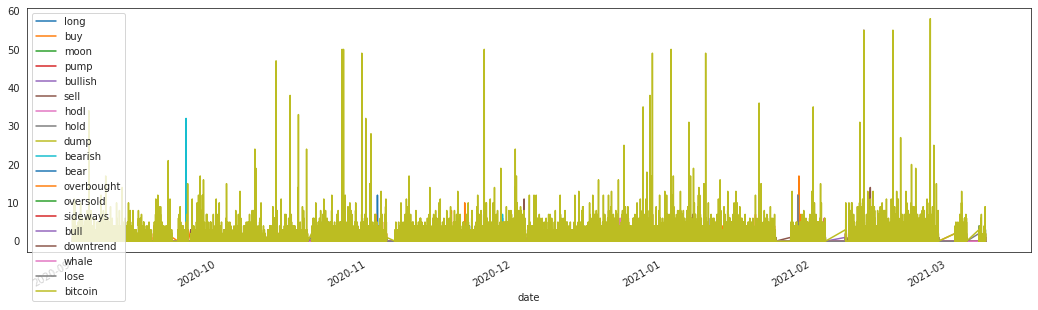

In [9]:
all_tracked.sample(frac=0.1).plot(figsize=(18,5))

<AxesSubplot:xlabel='date'>

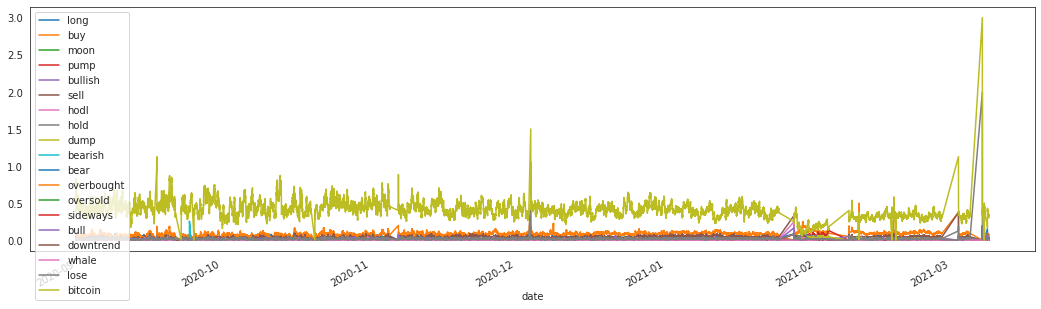

In [10]:
all_tracked_sma = all_tracked.rolling("4h").mean().dropna()
all_tracked_sma.sample(frac=0.1).plot(figsize=(18,5))

<AxesSubplot:xlabel='date'>

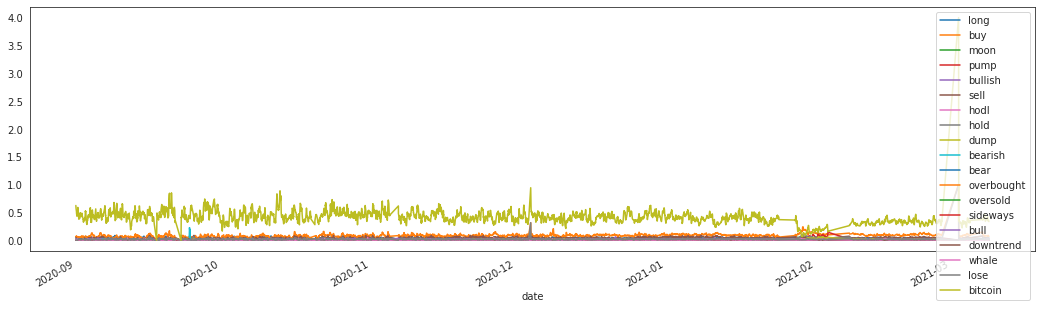

In [11]:
all_tracked_sma = all_tracked_sma.resample("5min").mean().dropna()
all_tracked_sma.sample(frac=0.1).plot(figsize=(18,5))

In [12]:
end_date = "2021-01-27 00:00:00"

<AxesSubplot:xlabel='date'>

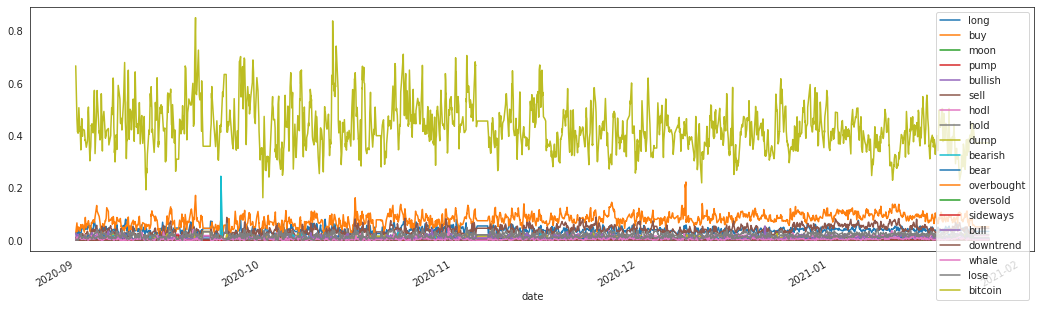

In [13]:
all_data, label = combine_ts(ohlcv.data.label[:end_date], all_tracked_sma[:end_date])
all_data.sample(frac=0.05).plot(figsize=(18,5))

In [14]:
all_data = pd.DataFrame(MinMaxScaler().fit_transform(all_data), index=all_data.index, columns=all_data.columns)

<AxesSubplot:ylabel='date'>

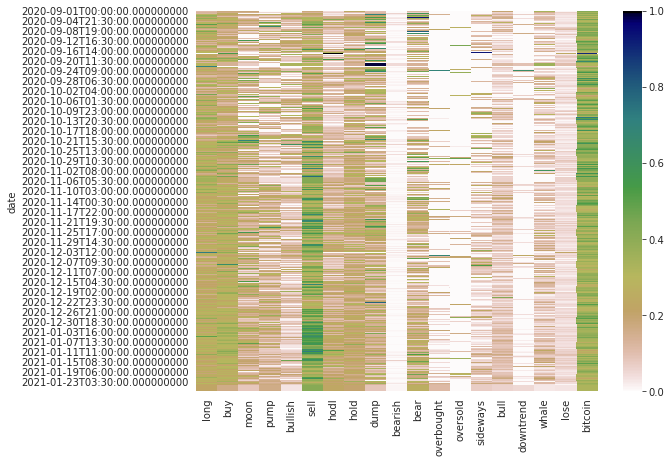

In [15]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(all_data, center=0.5, ax=ax, cmap=gist_earth_r)

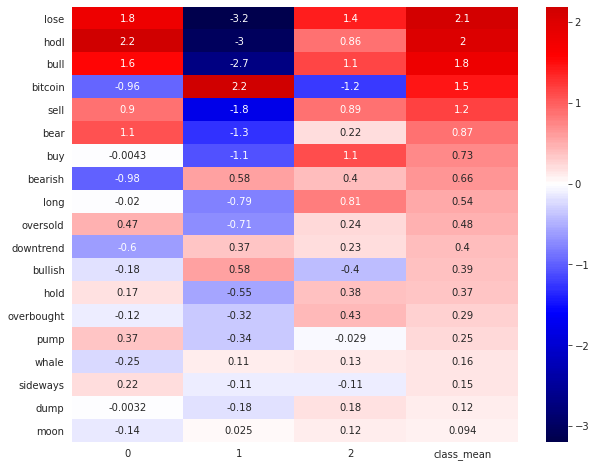

In [16]:
importance = linear_importance(all_data, label)

In [17]:
ohlcv.add_returns("1D")

In [18]:
#for buzzword in all_buzzwords:
#    _ = causality(all_data[buzzword], ohlcv.data.returns)

# Filter buzzwords

In [19]:
selected_buzzwords = importance.index[:-4].to_list()
selected_buzzwords

['lose',
 'hodl',
 'bull',
 'bitcoin',
 'sell',
 'bear',
 'buy',
 'bearish',
 'long',
 'oversold',
 'downtrend',
 'bullish',
 'hold',
 'overbought',
 'pump']

In [20]:
selected_data = all_data[selected_buzzwords]

In [21]:
model = LogisticRegression(class_weight="balanced", max_iter=500)

In [22]:
cv = TimeCV()
y_tests, y_preds, y_probs = cv.cross_validate(selected_data, label, model)

Fetched train fold before 2020-08-25 00:00:00 and after 2020-10-15 00:00:00
Fetched test fold from 2020-09-01 00:00:00 to 2020-10-07 23:55:00
Training on fold 1/4 | Have: 29952 samples
Predicting on fold 1/4 | Have: 10656 samples
----------------------------------------------------------------------------------------------------
Fetched train fold before 2020-10-01 00:00:00 and after 2020-11-21 00:00:00
Fetched test fold from 2020-10-08 00:00:00 to 2020-11-13 23:55:00
Training on fold 2/4 | Have: 27936 samples
Predicting on fold 2/4 | Have: 10656 samples
----------------------------------------------------------------------------------------------------
Fetched train fold before 2020-11-07 00:00:00 and after 2020-12-28 00:00:00
Fetched test fold from 2020-11-14 00:00:00 to 2020-12-20 23:55:00
Training on fold 3/4 | Have: 27936 samples
Predicting on fold 3/4 | Have: 10656 samples
----------------------------------------------------------------------------------------------------
Fetched

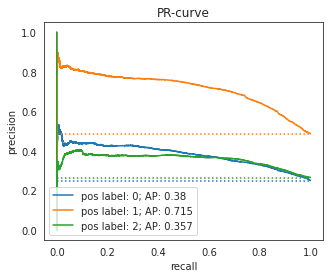

In [23]:
pr_curve(np.hstack(y_tests), np.hstack(y_preds), np.vstack(y_probs))

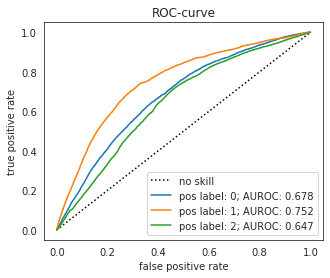

In [24]:
roc_curve(np.hstack(y_tests), np.hstack(y_preds), np.vstack(y_probs))

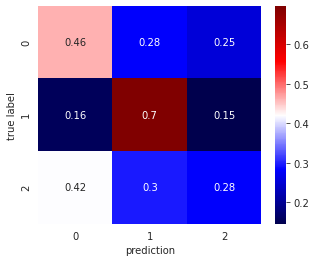

In [25]:
_ = confusion(np.hstack(y_tests), np.hstack(y_preds))

In [26]:
scores(np.hstack(y_tests), np.hstack(y_preds), np.vstack(y_probs)).T.head(2)

,0
matthews,0.255161
accuracy,0.528235


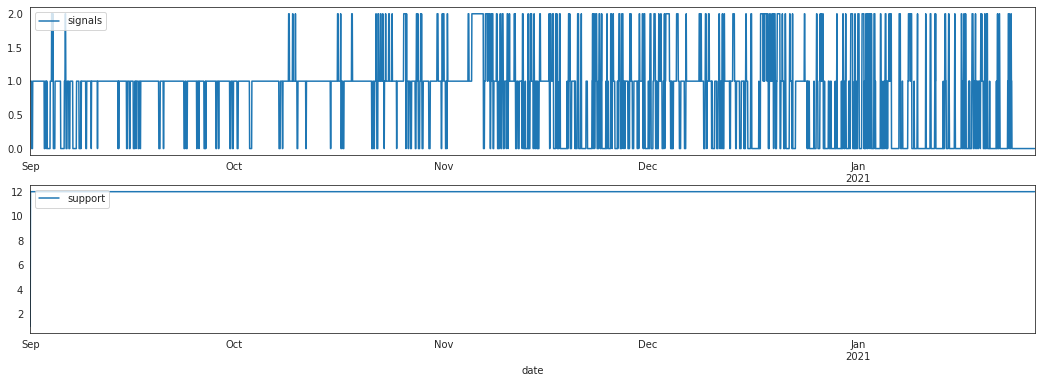

In [27]:
raw_signals = pd.Series(np.hstack(y_preds), index=selected_data.index)
signals, support = aggregate_signals(raw_signals, pace="1h")

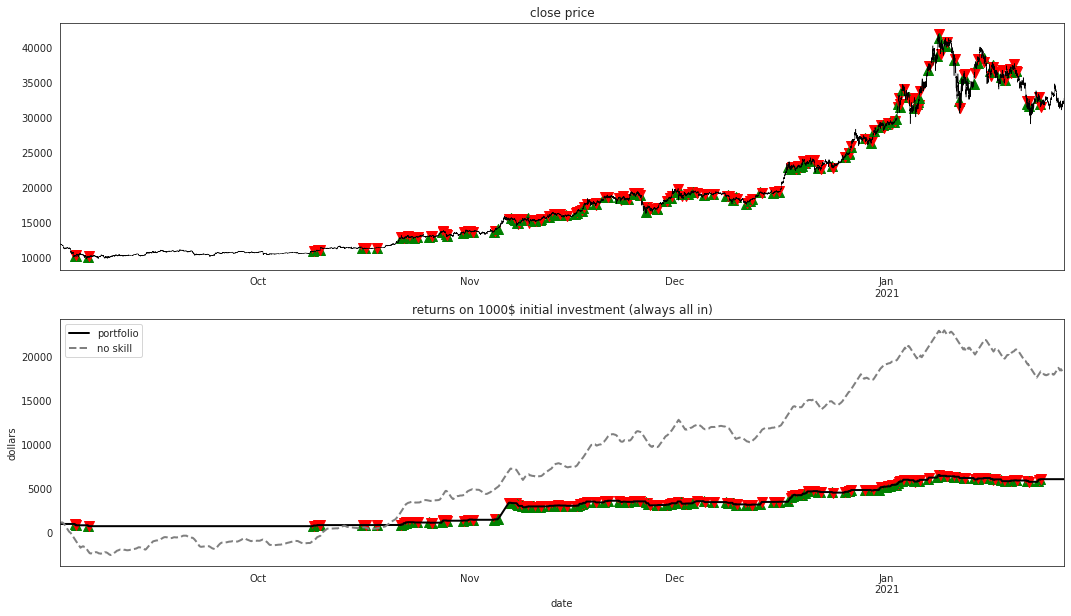

In [28]:
ts =  TradingSimulation(ohlcv.data)
portfolio = ts.simulate(signals)